source：https://www.ctolib.com/topics-126204.html

https://cloud.tencent.com/developer/article/1032160

## 1 加载数据
数据为：北京PM2.5数据集

In [11]:
import pandas as pd 
data_path='files/data/Python89/PRSA_data_2010.1.1-2014.12.31.csv'
dataset=pd.read_csv(data_path)
dataset.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


字段说明

1. No: 行数
2. year:年份
2. month: 月份
3. day: 一个月中的第几天
4. hour:当天中的第几小时
5. pm2.5: PM2.5 concentration
6. DEWP: 露点，露点温度（空气中所含的气态水达到饱和而凝结成液态水所需要降至的温度）
7. TEMP: 温度
8. PRES: 气压
9. cbwd:风向
10. Iws:风速
11. Is:积雪的时间
12. Ir: 累积的下雨时数

###  数据清洗
- 第一天的pm2.5值都为NA，所以要删除
- 时间信息整合为一个日期时间
- 空值处理
- 每一列的列名不是明确，然后重新命名
- 处理后的数据保存到文件pollution.csv

In [15]:
from pandas import read_csv
from datetime import datetime
# 加载数据
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(data_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# 重新命名
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 用0填充空值
dataset['pollution'].fillna(0, inplace=True)
# 删除前24小时的数据
dataset = dataset[24:]
# 保存数据到新文件
dataset.to_csv('files/data/Python89/pollution.csv')
# 输出处理后的数据前5行
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 数据分布
我们查看下数据分布，因为风向是离散变量，所以不将其画图

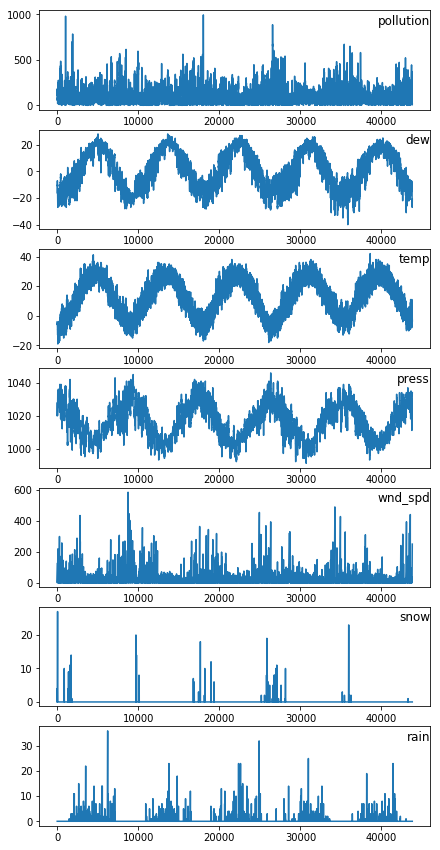

In [31]:
import matplotlib.pyplot as plt
# 加载数据
dataset=pd.read_csv('files/data/Python89/pollution.csv',header=0,index_col=0)
values=dataset.values
# 分组
groups=[0,1,2,3,5,6,7]
i=1

plt.figure(figsize=(7,15))

for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y=0.8,loc='right')
    i+=1
plt.show()

## 2 多变量LSTM预测模型
### 2.1 LSTM数据准备
第一步是为 LSTM 模型准备污染数据集，这涉及将数据集用作监督学习问题以及输入变量归一化。

我们将监督学习问题设定为：根据上一个时间段的污染指数和天气条件，预测当前时刻（t）的污染情况。

这个表述简单直接，只是为了说明问题。你可以探索的一些替代方案包括：

- 根据过去一天的天气情况和污染状况，预测下一个小时的污染状况。
- 根据过去一天的天气情况和污染状况以及下一个小时的「预期」天气条件，预测下一个小时的污染状况。

我们可以使用之前博客中编写的 series_to_supervised（）函数来转换数据集：

如何用 Python 将时间序列问题转换为监督学习问题（https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/）
首先加载「pollution.csv」数据集。给风速特征打上标注（整型编码）。如果你再深入一点就会发现，整形编码可以进一步进行一位有效编码（one-hot encoding）。

接下来，所有特征都被归一化，然后数据集转换成监督学习问题。之后，删除要预测的时刻（t）的天气变量。

In [36]:
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

In [39]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('files/data/Python89/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


这个数据准备过程很简单，我们可以深入了解更多相关知识，包括：

- 对风速进行一位有效编码
- 用差值和季节性调整使所有序列数据恒定
- 提供超过 1 小时的输入时间步长

最后也可能是最重要的一点，在学习序列预测问题时，LSTM 通过时间步进行反向传播。

## 定义和拟合模型
首先，我们必须将准备好的数据集分成训练集和测试集。为了加快此次讲解的模型训练，我们将仅使用第一年的数据来拟合模型，然后用其余 4 年的数据进行评估。

下面的示例将数据集分成训练集和测试集，然后将训练集和测试集分别分成输入和输出变量。最后，将输入（X）重构为 LSTM 预期的 3D 格式，即 [样本，时间步，特征]

In [54]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


我们现在可以定义和拟合 LSTM 模型了。

我们将在第一个隐藏层中定义具有 50 个神经元的 LSTM，在输出层中定义 1 个用于预测污染的神经元。输入数据维度将是 1 个具有 8 个特征的时间步长。

我们将使用平均绝对误差（MAE）损失函数和高效的随机梯度下降的 Adam 版本。

该模型将适用于 50 个 epoch，批大小为 72 的训练。请记住，每个批结束时，Keras 中的 LSTM 的内部状态都将重置，因此内部状态是天数的函数可能有所帮助（试着证明它）。

最后，我们通过在 fit（）函数中设置 validation_data 参数来跟踪训练过程中的训练和测试损失，并在运行结束时绘制训练和测试损失图。

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0564 - val_loss: 0.0563
Epoch 2/50
 - 1s - loss: 0.0369 - val_loss: 0.0539
Epoch 3/50
 - 1s - loss: 0.0220 - val_loss: 0.0420
Epoch 4/50
 - 1s - loss: 0.0172 - val_loss: 0.0374
Epoch 5/50
 - 1s - loss: 0.0157 - val_loss: 0.0249
Epoch 6/50
 - 1s - loss: 0.0149 - val_loss: 0.0185
Epoch 7/50
 - 1s - loss: 0.0147 - val_loss: 0.0170
Epoch 8/50
 - 1s - loss: 0.0148 - val_loss: 0.0156
Epoch 9/50
 - 1s - loss: 0.0146 - val_loss: 0.0152
Epoch 10/50
 - 1s - loss: 0.0148 - val_loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 12/50
 - 1s - loss: 0.0147 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0142
Epoch 14/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 15/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 16/50
 - 1s - loss: 0.0146 - val_loss: 0.0137
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 19/50
 - 1s - loss

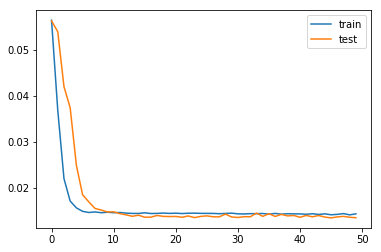

In [44]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3 评估模型

模型拟合后，我们可以预测整个测试数据集。

我们将预测与测试数据集相结合，并调整测试数据集的规模。我们还用预期的污染指数来调整测试数据集的规模。

通过初始预测值和实际值，我们可以计算模型的误差分数。在这种情况下，我们可以计算出与变量相同的单元误差的均方根误差（RMSE）。

In [55]:
from sklearn.metrics import mean_squared_error
import numpy as np

(35039, 1, 8)


In [56]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.374
